# <font color = "blue"> Assignment 6- Recommendation Systems

### <font color = "green"> Make the necessary imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.metrics.pairwise import cosine_distances, cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split as sklearn_train_test
from math import sqrt

from collections import defaultdict
from surprise import SVD
from surprise import Dataset

from surprise import KNNWithMeans
#from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise import Reader
from surprise import BaselineOnly
from surprise.model_selection import cross_validate

from apyori import apriori
from scipy.linalg import svd

from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, confusion_matrix, classification_report
import os

# <font color = "blue"> Q1. Read and explore the given dataset.

### <font color = "green"> Read the data

In [2]:
electronic_df = pd.read_csv("ratings_Electronics.csv", names = ["userId", "productId", "ratings", "timestamp"])
electronic_df.head()

,userId,productId,ratings,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


### <font color = "green"> Explore the data

In [3]:
electronic_df.shape

(7824482, 4)

In [4]:
electronic_df["productId"].nunique()

476002

In [5]:
electronic_df["userId"].nunique()

4201696

In [6]:
electronic_df["ratings"].nunique()

5

In [7]:
electronic_df["ratings"].unique()

array([5., 1., 3., 2., 4.])

### OBSERVATIONS

<font color = "purple"> 1. We see that there are 5 ratings 1-5 </font>

<font color = "purple"> 2. Number of users is almost 10 times as many as products 4201696 vs 476002 </font>

### <font color = "green"> Dropping the timestamp as it doesnt add value

In [8]:
electronic_df.drop(["timestamp"], axis = 1, inplace = True)

In [9]:
electronic_df.head()

,userId,productId,ratings
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0


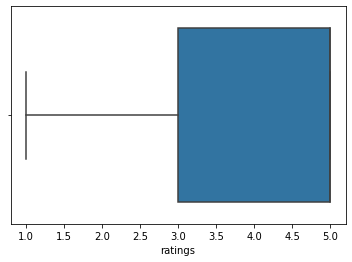

In [10]:
sns.boxplot("ratings", data = electronic_df)

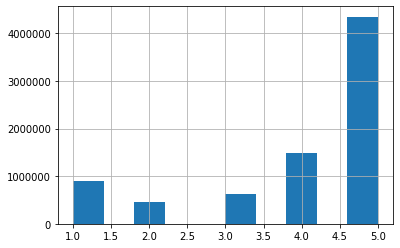

In [11]:
electronic_df["ratings"].hist()

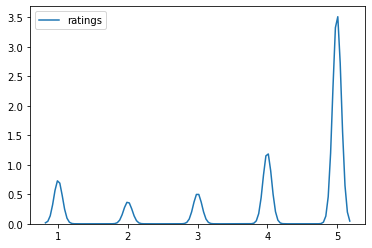

In [12]:
sns.kdeplot(electronic_df["ratings"])

### OBSERVATIONS

<font color = "purple"> 1. The largest number of ratings are at 5 </font>

<font color = "purple"> 2. 2 is the least popular rating </font>

<font color = "purple"> 3. The set is biased towards the higher ratings </font>

# <font color = "blue"> Q2. Take a subset of the dataset to make it less sparse/ denser. ( For example, keep the users only who has given 50 or more number of ratings )

### <font color = "green"> Group the data by users

In [13]:
user_ratings_df = pd.DataFrame(electronic_df.groupby("userId")["ratings"].count())

### <font color = "green"> Subset the data

In [14]:
user_ratings_df.head()

,ratings
userId,
A00000262KYZUE4J55XGL,1
A000063614T1OE0BUSKUT,2
A00009182QVLSWIGHLS1B,1
A00009661LC9LQPGKJ24G,1
A00010809P09NUU6ZP6H,1


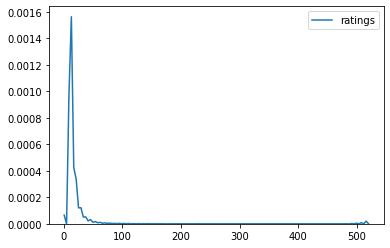

In [15]:
sns.kdeplot(user_ratings_df["ratings"])

In [16]:
user_ratings_df["ratings"].max()

520

In [17]:
user_ratings_df["ratings"].median()

1.0

In [18]:
for i in [20, 40, 60, 80, 100]:
    print("number of ratings = " + str(i) + ": " + str(user_ratings_df[user_ratings_df["ratings"]>i].count()))

number of ratings = 20: ratings    12011
dtype: int64
number of ratings = 40: ratings    2519
dtype: int64
number of ratings = 60: ratings    951
dtype: int64
number of ratings = 80: ratings    479
dtype: int64
number of ratings = 100: ratings    280
dtype: int64


### OBSERVATIONS

<font color = "purple"> 1. A large majority of the set has less than 50 ratings </font>

<font color = "purple"> 2. The maximum number of ratings for an object is 520 </font>

<font color = "purple"> 3. The distribution has a very long right tail </font>

### <font color = "green"> Due to memory restrictions, keeping the data limited

In [19]:
user_ratings_df = user_ratings_df[user_ratings_df["ratings"]>100]

### <font color = "green"> Creating a dataset which only has the above selected users

In [20]:
user_ratings_df = user_ratings_df.reset_index()

In [21]:
user_ratings_df

,userId,ratings
0,A100UD67AHFODS,116
1,A100WO06OQR8BQ,132
2,A10PEXB6XAQ5XF,107
3,A10Y058K7B96C6,123
4,A10ZFE6YE0UHW8,130
...,...,...
275,AY6A8KPYCE6B0,115
276,AYB4ELCS5AM8P,168
277,AZ515FFZ7I2P7,144
278,AZAC8O310IK4E,103


### <font color = "green"> Checking if users in base dataset match users in the dataset with users over 100 ratings. Creating a column for true/false based on this existence

In [22]:
electronic_df["users_selected_col"] = ""
electronic_df = electronic_df.assign(users_selected_col = electronic_df["userId"].isin(user_ratings_df["userId"]))

### <font color = "green"> Reducing the dataset on basis of existence in the dataset

In [23]:
electronic_df = electronic_df[electronic_df["users_selected_col"] == True]

### <font color = "green"> Dropping the selection column as it is no longer required

In [24]:
electronic_df.drop(["users_selected_col"],inplace = True, axis = 1)

# <font color = "blue"> Q3. Build Popularity Recommender model

### <font color = "green"> Build Recommender model. Group by product based on ratings median, mean and count

In [25]:
product_df = pd.DataFrame(electronic_df.groupby("productId")["ratings"].count())

### <font color = "green"> Add median rating as a column

In [26]:
product_df["median_rating"] = pd.DataFrame(electronic_df.groupby("productId")["ratings"].median())

### <font color = "green"> Add mean rating as a column

In [27]:
product_df["mean_rating"] = pd.DataFrame(electronic_df.groupby("productId")["ratings"].mean())

### <font color = "green"> Calculate a weighted rating based on number of users who have rated product

In [28]:
def pop_recommender(k, returnall):
    max_ratings = product_df["ratings"].max()
    # taking max of median and mean
    product_df ["calculated_rating"] = np.where(product_df["mean_rating"] > product_df["median_rating"], product_df["mean_rating"], product_df["median_rating"])
    ## applying a penalty for lower number of ratings
    ## The perfect rating would be the one with maximum ratings in the set
    ## maximum ratings/maximum ratings needs no penalty
    ## (maximum ratings - received ratings) / maximum ratings should be the penalty
    product_df ["calculated_rating"] = product_df["calculated_rating"] - (((max_ratings - product_df["ratings"])/max_ratings)* (product_df["calculated_rating"]/2) )
    if returnall:
        return product_df.sort_values(by = "calculated_rating", ascending = False)
    else:
        return (product_df.sort_values(by = "calculated_rating", ascending = False) [:k])

### <font color = "green"> Extracting the top 5

In [29]:
pop_recommender(5, False)

,ratings,median_rating,mean_rating,calculated_rating
productId,,,,
B003ES5ZUU,54,5.0,5.000000,4.401408
B004CLYEDC,49,5.0,4.673469,4.225352
B00829TIEK,49,5.0,4.510204,4.225352
B0088CJT4U,71,4.0,4.225352,4.225352
B000N99BBC,47,5.0,4.765957,4.154930


### <font color = "green"> To validate the results, we will build another popularity based model which considers 5 star ratings

In [30]:
five_star_df = pd.DataFrame(electronic_df.groupby(["productId", "ratings"])["userId"].count())
total_ratings_df = pd.DataFrame(electronic_df.groupby(["productId"])["userId"].count())

In [31]:
five_star_df.reset_index(inplace = True)
five_star_df = five_star_df[five_star_df["ratings"] == 5]
five_star_df.columns = ["productId", "rating", "ratings"]

In [32]:
total_ratings_df.reset_index(inplace=True)
total_ratings_df.columns = ["productId", "total_ratings"] 

In [33]:
five_star_df.set_index("productId",inplace=True)
total_ratings_df.set_index("productId",inplace=True)

In [34]:
five_star_df = five_star_df.join([total_ratings_df], how='inner')

### <font color = "green"> The model uses the ratio of 5 star ratings to total ratings and rationalizes them with a penalty based on number of ratings. The lesser the number of ratings, the lesser the value of 5 stars

In [35]:
max_5_star = five_star_df["ratings"].max()
five_star_df["five_Star_index"] = 5 - ((max_5_star - five_star_df["ratings"])/max_5_star)

In [36]:
five_star_df = five_star_df.sort_values(by = "five_Star_index", ascending = False)

In [37]:
pop_recommender_1 = pop_recommender(100, False)
pop_recommender_2 = five_star_df[:100]
pop_recommender_2.reset_index(inplace= True)
pop_recommender_1.reset_index(inplace= True)

### <font color = "green"> Now we compare these models

In [38]:
accuracy = (pop_recommender_1["productId"].isin(pop_recommender_2["productId"])).astype(int)

In [39]:
accuracy.sum()/100

0.84

### OBSERVATIONS

<font color = "purple"> 1. Both our models have 84% coherence. The first 100 have 84 entries that overlap. Though not in the same positions </font>

<font color = "purple"> 2. This goes to show that popularity models will work similarly regardless of their basic premise </font>

<font color = "purple"> 3. The other thing to note is that these models are user independent. So there is no contextualization </font>

<font color = "purple"> 4. Finally, it is important to note that unlike the collaborative filtering model, there is no training sets here. The popularity is gauged on data already available. So there can be no measurement metrics for it </font>

# <font color = "blue"> Q4. Split the data randomly into a train and test dataset. ( For example, split it in 70/30 ratio)

### <font color = "green"> Load the data

In [40]:
reader = Reader(line_format="user item rating", rating_scale=(1, 5))
data = Dataset.load_from_df(electronic_df, reader)

### <font color = "green"> Train Test Split

In [41]:
train, test = train_test_split(data, test_size = .3)

# <font color = "blue"> Q5. Build Collaborative Filtering model

### <font color = "green"> Build Collaborative Filtering model

### <font color = "green"> Create KNN with Means algorithm set up with user user filtering

In [42]:
algo = KNNWithMeans(k = 50, sim_options = {"name": "pearson_baseline", "user_based":True})
algo.fit(train)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


### <font color = "green"> Build Collaborative Filtering model using the algo created

In [43]:
def collab_recommender_user(user, k, fullset, estimated):
    prediction = algo.test(test)
    recommended_df = pd.DataFrame(columns = ["user","product", "rating","estimated", "k"])
    
    # collect items that are predicted for this user
    i = 0
    for pred in prediction:
        if (pred.uid == user) and (pred.est>3.5):
            if "actual_k" in pred.details.keys():                
                recommended_df.loc[i] = [pred.uid, pred.iid, pred.r_ui, pred.est, pred.details["actual_k"]]
            else:
                recommended_df.loc[i] = [pred.uid, pred.iid, pred.r_ui, pred.est, 0]
            i = i + 1
    
    ## factoring for number of neighbours and applying penalty for single observations
    max_k = recommended_df["k"].max()
    recommended_df ["calculated_rating"] = recommended_df["estimated"] - (((max_k - recommended_df["k"])/max_k)* (recommended_df["estimated"]/2) ) 
    # sort items as per rating
    if estimated:
        recommended_df = recommended_df.sort_values(by = "calculated_rating", ascending = False)
    else:
        recommended_df = recommended_df.sort_values(by = "rating", ascending = False)
    
    #return the dataset selected
    if fullset:
        return recommended_df
    else:
        return recommended_df[:k]

### OBSERVATIONS

<font color = "purple"> 1. Without using a penalty, this method will return the products which have had only a few ratings </font>


### <font color = "green"> Call the model for a test

In [44]:
uid = "A100UD67AHFODS"
user_collab = collab_recommender_user(uid, 5, False, True)
user_collab

,user,product,rating,estimated,k,calculated_rating
10,A100UD67AHFODS,B00F0DD0I6,5.0,4.937411,5,4.93741
15,A100UD67AHFODS,B00HHRP11C,5.0,5.000000,3,4
13,A100UD67AHFODS,B000Q8UAWY,5.0,4.491033,3,3.59283
17,A100UD67AHFODS,B000HZDF8W,5.0,4.869688,2,3.40878
30,A100UD67AHFODS,B002HZW7CK,5.0,4.443093,2,3.11017


### OBSERVATIONS

<font color = "purple"> 1. The reduction of the data has reduced the number of neighbours available, however, the items with largest number of neighbours and estimated ratings are coming to the front. This is a good thing in terms of our recommendation accuracy</font>


### <font color = "green"> Create KNN with Means algorithm set up with item item filtering

In [45]:
prod_algo = KNNWithMeans(k = 50, sim_options = {"name": "pearson_baseline", "user_based":False})
prod_algo.fit(train)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


### <font color = "green"> Build Collaborative Filtering model using the algo created

In [46]:
def collab_recommender_prod(product, k, fullset, estimated):
    prediction = prod_algo.test(test)
    recommended_df = pd.DataFrame(columns = ["user","product", "rating","estimated","k"])
    # collect items
    i = 0
    for pred in prediction:
        if (pred.iid != product) and (pred.est>3.5):
            if "actual_k" in pred.details.keys():                
                recommended_df.loc[i] = [pred.uid, pred.iid, pred.r_ui, pred.est, pred.details["actual_k"]]
            else:
                recommended_df.loc[i] = [pred.uid, pred.iid, pred.r_ui, pred.est, 0]
            i = i + 1
    
    ## factoring for number of neighbours and applying penalty for single observations
    max_k = recommended_df["k"].max()
    recommended_df ["calculated_rating"] = recommended_df["estimated"] - (((max_k - recommended_df["k"])/max_k)* (recommended_df["estimated"]/2) ) 

    # sort items as per rating
    if estimated: 
        recommended_df = recommended_df.sort_values(by = "calculated_rating", ascending = False)
    else:
        recommended_df = recommended_df.sort_values(by = "rating", ascending = False)
    if fullset:
        return recommended_df
    else:
        return recommended_df[:k]

### OBSERVATIONS

<font color = "purple"> 1. Adding a penalty here ensures that high rating items with low confidence do not get prioritized over others with larger number of ratings </font>


### <font color = "green"> Call the model for a test

In [47]:
pid = "B003ES5ZUU"
product_collab = collab_recommender_prod(pid, 5, False, True)
product_collab

,user,product,rating,estimated,k,calculated_rating
4359,A22CW0ZHY3NJH8,B0082E9K7U,4.0,4.693092,29,4.69309
8381,A25C2M3QF9G7OQ,B00FSA8VQ2,5.0,4.752935,27,4.58904
427,A25C2M3QF9G7OQ,B00DTZYHX4,5.0,4.802022,26,4.55364
2098,A25C2M3QF9G7OQ,B00GMTN96U,5.0,4.816269,25,4.48411
2914,A36K2N527TXXJN,B0082E9K7U,4.0,4.809302,25,4.47763


### OBSERVATIONS

<font color = "purple"> 1. The reduction of the data has reduced the number of neighbours available, however, the items with largest number of neighbours and estimated ratings are coming to the front. This is a good thing in terms of our recommendation accuracy</font>


# <font color = "blue"> Q6. Evaluate the above model. ( Once the model is trained on the training data, it can be used to compute the error (like RMSE) on predictions made on the test data.) You can also use a different method to evaluate the models.

### <font color = "green"> Determine metrics

In [65]:
product_collab_pred = collab_recommender_prod(pid, 0, True, True)
user_collab_pred = collab_recommender_user(uid, 0, True, True)

In [66]:
rms_product = sqrt(mean_squared_error(product_collab_pred["rating"],product_collab_pred["estimated"]))
rms_user = sqrt(mean_squared_error(user_collab_pred["rating"],user_collab_pred["estimated"]))

In [67]:
rms_product

0.7918173615970596

In [68]:
rms_user

0.345384477961416

In [69]:
from sklearn.metrics import accuracy_score
print(accuracy_score(product_collab_pred["rating"], np.round(product_collab_pred["estimated"])))

0.6176903751191198


### OBSERVATIONS

<font color = "purple"> 1. The accuracy is around 60%, which means we get it right around 60% of the times</font>

<font color = "purple"> 2. The RMS for user is lower than RMS for products. This could stem from a larger number of samples against which to compare for users</font>


### <font color = "green"> Run a cross validation for user user model

In [53]:
user_output = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0197  1.0449  1.0241  1.0261  1.0167  1.0263  0.0099  
MAE (testset)     0.7501  0.7624  0.7516  0.7530  0.7473  0.7529  0.0051  
Fit time          0.19    0.23    0.21    0.22    0.16    0.20    0.03    
Test time         0.13    0.14    0.14    0.11    0.

### OBSERVATIONS

<font color = "purple"> 1. RMSE and MAE numbers are very stable for the user user collaborative filter</font>

<font color = "purple"> 2. The standard deviation is quite low and the fit time is in acceptable bounds. However, this will increase exponentially as the number of cases increase</font>


### <font color = "green"> Run a cross validation for item item model. Reduce the dataset to 50% its size using sampling to avoid out of memory errors

In [54]:
electronic_df_sampled = electronic_df.sample(frac = 0.5)
data_reduced = Dataset.load_from_df(electronic_df_sampled, reader)
prod_output = cross_validate(prod_algo, data_reduced, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.1218  1.0797  1.0714  1.0613  1.0948  1.0858  0.0211  
MAE (testset)     0.8056  0.7853  0.7815  0.7726  0.7943  0.7879  0.0113  
Fit time          8.44    7.78    8.35    7.23    7.50    7.86    0.47    
Test time         0.84    0.29    0.41    0.25    0.

### OBSERVATIONS

<font color = "purple"> 1. RMSE and MAE numbers are very stable for the user user collaborative filter</font>

<font color = "purple"> 2. The standard deviation is quite low and the fit time is in acceptable bounds. </font>

<font color = "purple"> 3. The time consumed here is far more due to the larger number of items to examine (user inputs) </font>


### <font color = "green"> Checking what the output looks like

In [55]:
prod_output

{'test_rmse': array([1.12184958, 1.07966479, 1.0714453 , 1.06133688, 1.09484896]),
 'test_mae': array([0.80556883, 0.78532478, 0.78154409, 0.77263278, 0.79434977]),
 'fit_time': (8.442301988601685,
  7.78322434425354,
  8.34732699394226,
  7.229888200759888,
  7.504071950912476),
 'test_time': (0.8417649269104004,
  0.28524231910705566,
  0.4135017395019531,
  0.2473444938659668,
  0.45579099655151367)}

In [56]:
user_output

{'test_rmse': array([1.0196533 , 1.04491534, 1.02406862, 1.02605211, 1.01669712]),
 'test_mae': array([0.75005115, 0.76235637, 0.75157114, 0.75298903, 0.74733617]),
 'fit_time': (0.18849802017211914,
  0.23338007926940918,
  0.21243500709533691,
  0.21941733360290527,
  0.15957283973693848),
 'test_time': (0.12766122817993164,
  0.13563919067382812,
  0.14162421226501465,
  0.10970664024353027,
  0.10072970390319824)}

### <font color = "green"> Compare models

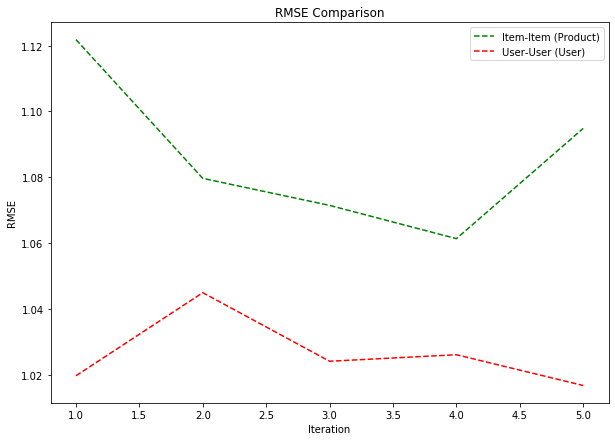

In [57]:
plt.figure(figsize = (10,7))
plt.plot(range(1,6), prod_output["test_rmse"],"g--", label = "Item-Item (Product)")
plt.plot(range(1,6), user_output["test_rmse"],"r--", label = "User-User (User)")
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.title("RMSE Comparison")
plt.legend()

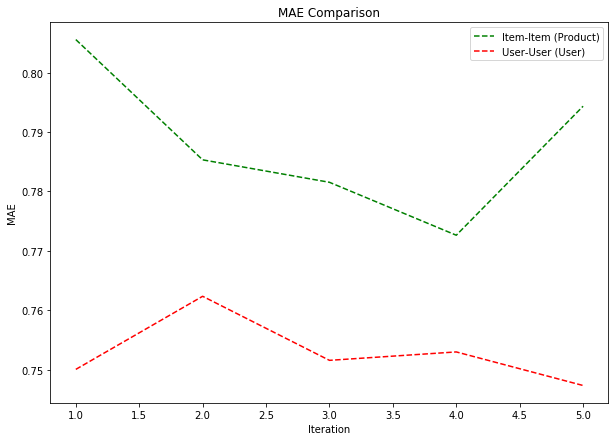

In [58]:
plt.figure(figsize = (10,7))
plt.plot(range(1,6), prod_output["test_mae"],"g--", label = "Item-Item (Product)")
plt.plot(range(1,6), user_output["test_mae"],"r--", label = "User-User (User)")
plt.xlabel("Iteration")
plt.ylabel("MAE")
plt.title("MAE Comparison")
plt.legend()

### OBSERVATIONS

<font color = "purple"> 1. The user - user filter is doing much better over a validation. This means that we should try and leverage the dimension with the higher number of entries</font>


In [59]:
print("Item-Item (Product) mean of MAE: ", np.mean(prod_output["test_mae"]))
print("User-User (User) mean of MAE: ", np.mean(user_output["test_mae"]))
print("Item-Item (Product) mean of RMSE: ", np.mean(prod_output["test_rmse"]))
print("User-User (User) mean of RMSE: ", np.mean(user_output["test_rmse"]))
print("Item-Item (Product) std of MAE: ", np.std(prod_output["test_mae"]))
print("User-User (User) std of MAE: ", np.std(user_output["test_mae"]))
print("Item-Item (Product) std of RMSE: ", np.std(prod_output["test_rmse"]))
print("User-User (User) std of RMSE: ", np.std(user_output["test_rmse"]))

Item-Item (Product) mean of MAE:  0.7878840519621484
User-User (User) mean of MAE:  0.7528607729228052
Item-Item (Product) mean of RMSE:  1.0858291018675756
User-User (User) mean of RMSE:  1.0262772983756843
Item-Item (Product) std of MAE:  0.011259692667085819
User-User (User) std of MAE:  0.005104139509314754
Item-Item (Product) std of RMSE:  0.021088356797198365
User-User (User) std of RMSE:  0.009878894569786467


# <font color = "blue"> Q7. Get top - K ( K = 5) recommendations. Since our goal is to recommend new products to each user based on his/her habits, we will recommend 5 new products

### <font color = "green"> Get top 5 from popularity recommender system

In [60]:
pop_recommender(5, False)

,ratings,median_rating,mean_rating,calculated_rating
productId,,,,
B003ES5ZUU,54,5.0,5.000000,4.401408
B004CLYEDC,49,5.0,4.673469,4.225352
B00829TIEK,49,5.0,4.510204,4.225352
B0088CJT4U,71,4.0,4.225352,4.225352
B000N99BBC,47,5.0,4.765957,4.154930


### <font color = "green"> Get top 5 from Item Item Collaborative Filtering Recommender system 

In [61]:
collab_recommender_prod(pid, 5, False, True)

,user,product,rating,estimated,k,calculated_rating
1871,AWPODHOB4GFWL,B0082E9K7U,5.0,4.996124,23,4.99612
4871,A3A4ZAIBQWKOZS,B00HZWJGS8,5.0,5.000000,18,4.45652
3749,A3OXHLG6DIBRW8,B000VX6XL6,5.0,4.950098,18,4.41204
2048,A25C2M3QF9G7OQ,B00GMTN96U,5.0,5.000000,17,4.34783
4646,A3A4ZAIBQWKOZS,B00G4V0QSK,5.0,5.000000,16,4.23913


### <font color = "green"> Get top 5 from User User Collaborative Filtering Recommender system 

In [62]:
collab_recommender_user(uid, 5, False, True)

,user,product,rating,estimated,k,calculated_rating
9,A100UD67AHFODS,B00F0DD0I6,5.0,5.0,11,5
14,A100UD67AHFODS,B00HHRP11C,5.0,5.0,7,4.09091
12,A100UD67AHFODS,B000Q8UAWY,5.0,5.0,7,4.09091
27,A100UD67AHFODS,B005CLPP8E,5.0,5.0,5,3.63636
17,A100UD67AHFODS,B001W26TIW,5.0,5.0,2,2.95455


# <font color = "blue"> Q8. Summarise your insights

### <font color = "green"> Lets take a look at the output for both collaborative models 

### <font color = "green"> Item Item Collaborative Filtering

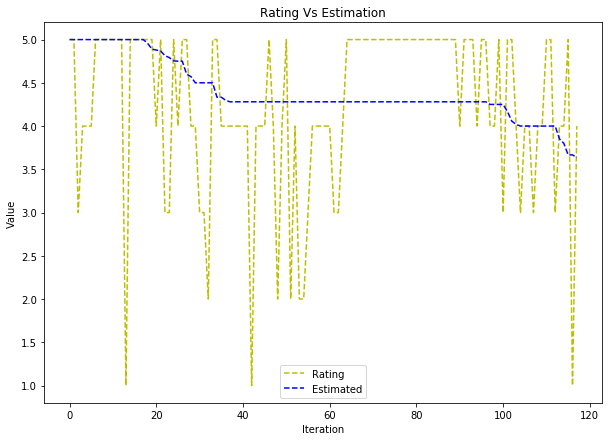

In [63]:
plt.figure(figsize = (10,7))
product_collab_pred = product_collab_pred.sample(frac=0.01)
num_ratings = product_collab_pred ["rating"].count()
product_collab_pred = product_collab_pred.sort_values(by = "rating", ascending = False)
product_collab_pred = product_collab_pred.sort_values(by = "estimated", ascending = False)
plt.plot(range(0,num_ratings), product_collab_pred ["rating"],"y--", label = "Rating")
plt.plot(range(0,num_ratings), product_collab_pred ["estimated"],"b--", label = "Estimated")
plt.xlabel("Iteration")
plt.ylabel("Value")
plt.title("Rating Vs Estimation")
plt.legend()

### <font color = "green"> User User Collaborative Filtering

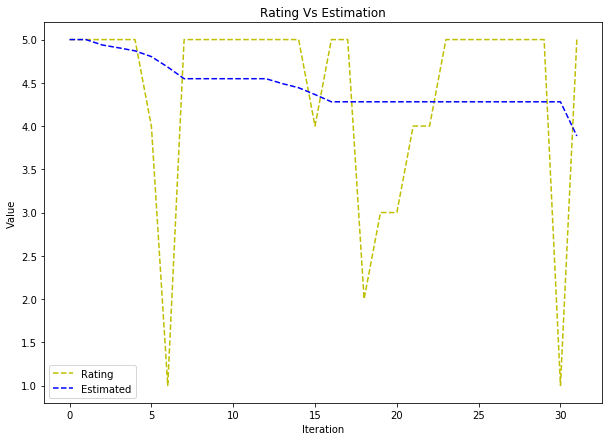

In [64]:
plt.figure(figsize = (10,7))
num_ratings = user_collab_pred ["rating"].count()
user_collab_pred = user_collab_pred.sort_values(by = "rating", ascending = False)
user_collab_pred = user_collab_pred.sort_values(by = "estimated", ascending = False)
plt.plot(range(0,num_ratings), user_collab_pred ["rating"],"y--", label = "Rating")
plt.plot(range(0,num_ratings), user_collab_pred ["estimated"],"b--", label = "Estimated")
plt.xlabel("Iteration")
plt.ylabel("Value")
plt.title("Rating Vs Estimation")
plt.legend()

### OBSERVATIONS

<font color = "purple"> 1. The user - user filter projects a smoother estimation against the user ratings. As pointed out previously, this implies that we can try and leverage the dimension with the higher number of entries for our recommendation system. i.e if the number of users is higher we use user user collaborative filtering, else we use item item collaborative filtering </font>


### OUR INSIGHTS FROM THIS ASSIGNMENT

<font color = "purple"> 1. We see that the collaborative filters do a better job of aligning with user interests than the pure popularity based recommender systems. However, the ease of implementation, the low computational complexity could mean that popularity based recommender systems can be used in certain opportunities. These systems could work very well if given a limited scope of product types, segments or user preferences to work inside.</font>

<font color = "purple"> 2. What is also evident is that there is a certain degree of bias towards products with fewer ratings but higher values. This correlates well with what we see. A lot of recommender systems, especially Amazon, tend to show objects with few high ratings higher than those with multiple higher ratings.</font>

<font color = "purple"> 3. To balance this out, we have introduced a penalty system that works backwards from the maximum times rated object. The penalty increases as the number of ratings decrease until the number of ratings available reaches 1. In which case, the penalty is almost half the value of the rating. This suppresses objects which have very few high ratings. </font>

<font color = "purple"> 4. In real life, we will have to seek a balance between prioritizing objects that have more reviews and trying to increase the popularity of items that may have high ratings but only a few user reviews.</font>

<font color = "purple"> 5. An ideal combination would be Content based recommendation systems for objects which are reviewed less, collaborative filtering for objects and users that have lots of ratings and preferences visible and popularity based filtering for users that have lower reviews/indicated interests. This would help us cover all frontiers</font>

<font color = "purple"> 6. What is also an important point to note, is that there is a significant performance concern here. At a few thousand records, we observed python usage of 4GB upwards. This indicates that the data for this recommendation systems must be segregated as much as possible. Different categories, price ranges and user segments. That helps keep the performance requirement in check and reduces cost of operation</font>

<font color = "purple"> 7. Further, there is the scope of optimizing the work done on the predictions returned. At this time, we are returning a subset from all the predictions. Instead, it could be fruitful to discover ways of inplace sorting and filtering from the subset data itself. </font>

<font color = "purple"> 8. In terms of accuracy metrics, we see that RMSE, MAE and Accuracy scores are all applicable on the results. What we can also attempt is the use of classification measures. However, the clear issue there is the existence of multiclass outputs which most methods are unable to deal with. We may have to categorize the outcomes into such categories that make classification, ROC_Scores possible.</font>

<font color = "purple"> 9. Since both popularity and collaborative filtering solutions may work well within defined boundaries and constraints, it becomes important to ask whether we actually need the additional customization offered by the collaborative filtering systems. It would depend on the cost of computation and development vs benefit analysis of the upsell/cross sell produced </font>

# <font color = "blue"> Assignment 6 - Recommendation Systems END